# Softmax réseau de nerones

## 1.Import les donées et les modules

In [ ]:
import tensorflow as tf # 2.3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

In [ ]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### 1.1 Traitement les données

In [ ]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = (train_image - 127.5)/127.5
test_image = (test_image - 127.5)/127.5 
# Transformation de type 
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

##2. Entraînement contradictoire avec la pénalité L1


####2.1 Modèle Softmax original 

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax') #kernel_regularizer
])

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history = model.fit(dataset,validation_data=test_dataset,epochs=10)

Epoch 1/10
235/235 [==============================] - 7s 24ms/step - loss: 0.4273 - acc: 0.8727 - val_loss: 0.2232 - val_acc: 0.9339
Epoch 2/10
235/235 [==============================] - 3s 12ms/step - loss: 0.2031 - acc: 0.9397 - val_loss: 0.1677 - val_acc: 0.9484
Epoch 3/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1493 - acc: 0.9561 - val_loss: 0.1562 - val_acc: 0.9516
Epoch 4/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1194 - acc: 0.9643 - val_loss: 0.1174 - val_acc: 0.9645
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1017 - acc: 0.9689 - val_loss: 0.1087 - val_acc: 0.9656
Epoch 6/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0889 - acc: 0.9716 - val_loss: 0.1006 - val_acc: 0.9656
Epoch 7/10
235/235 [==============================] - 4s 14ms/step - loss: 0.0774 - acc: 0.9758 - val_loss: 0.1056 - val_acc: 0.9671
Epoch 8/10
235/235 [==============================] - 4s 15ms/step - 

####2.2 Modèle Softmax qui a soustrait la pénalité L1.

In [ ]:
model_L1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax',name='dense3',kernel_regularizer=tf.keras.regularizers.L1(-0.3)) #kernel_regularizer
])

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model_L1.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history_L1 = model_L1.fit(dataset,validation_data=test_dataset,epochs=10) 


Epoch 1/10
235/235 [==============================] - 5s 16ms/step - loss: -48.3304 - acc: 0.8650 - val_loss: -71.0740 - val_acc: 0.9261
Epoch 2/10
235/235 [==============================] - 3s 13ms/step - loss: -93.4070 - acc: 0.9394 - val_loss: -116.0442 - val_acc: 0.9428
Epoch 3/10
235/235 [==============================] - 4s 15ms/step - loss: -138.4132 - acc: 0.9525 - val_loss: -161.0757 - val_acc: 0.9538
Epoch 4/10
235/235 [==============================] - 4s 17ms/step - loss: -183.4461 - acc: 0.9575 - val_loss: -206.0687 - val_acc: 0.9440
Epoch 5/10
235/235 [==============================] - 3s 13ms/step - loss: -228.5068 - acc: 0.9611 - val_loss: -251.1699 - val_acc: 0.9587
Epoch 6/10
235/235 [==============================] - 3s 11ms/step - loss: -273.5800 - acc: 0.9618 - val_loss: -296.2152 - val_acc: 0.9528
Epoch 7/10
235/235 [==============================] - 3s 13ms/step - loss: -318.6559 - acc: 0.9623 - val_loss: -341.2841 - val_acc: 0.9538
Epoch 8/10
235/235 [==========

##3.Implémentation la méthode FGSM(Fast Gradient Sign Method)
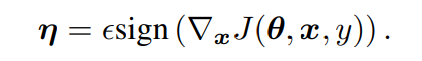

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

##4. Résultat de l'attaque contradictoire et de la défence 

####4.1 Fonction qui sert à afficher les images

In [ ]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette prédite par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, adv_label_L1, num = 10):
  fig = plt.figure(figsize=(2*num,3)) 
  for i in range(num):   
      plt.subplot(1,num,i+1) 
      plt.imshow(image[i,:,:],cmap='gray') 
      plt.title('{} -> {} -> {}'.format(label[i],adv_label[i],adv_label_L1[i]))
      plt.axis('off') 
  plt.show()


####4.2 Afficher les résultats

epsilons = 0:
313/313 [==============================] - 1s 2ms/step


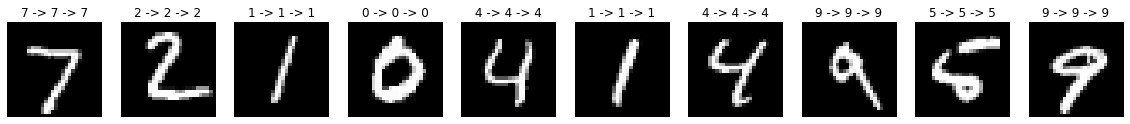

epsilons = 0.05:
313/313 [==============================] - 1s 3ms/step


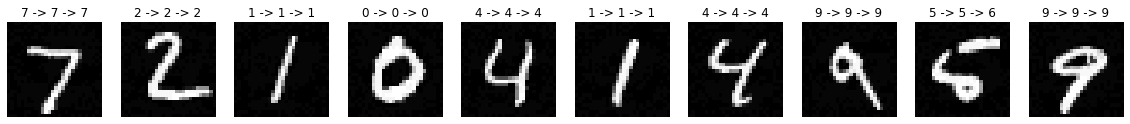

epsilons = 0.1:
313/313 [==============================] - 1s 2ms/step


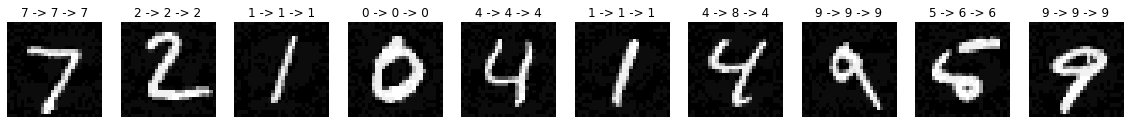

epsilons = 0.15:
313/313 [==============================] - 1s 4ms/step


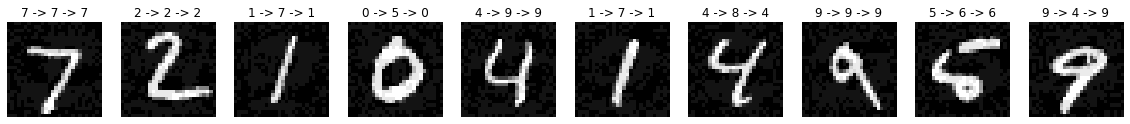

epsilons = 0.2:
313/313 [==============================] - 1s 2ms/step


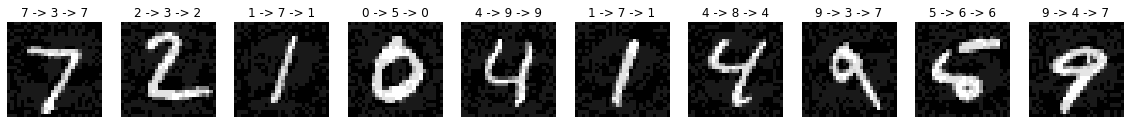

epsilons = 0.25:
313/313 [==============================] - 1s 3ms/step


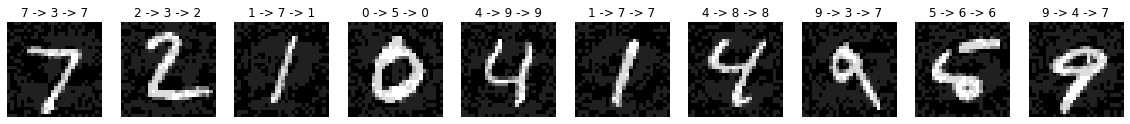

epsilons = 0.3:
313/313 [==============================] - 1s 2ms/step


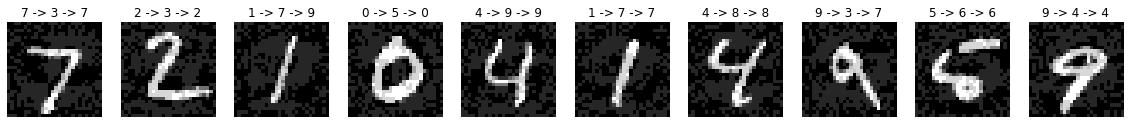

In [ ]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
perturbations = create_adversarial_pattern(test_image, test_labels)
adv_acc_list = []
adv_acc_list_L1 = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])

  adv_predict_label_L1 = model_L1.predict(adv_image)
  adv_predict_label_L1 = np.array([np.argmax(i) for i in adv_predict_label_L1])

  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])

  score_L1 = model_L1.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list_L1.append(score_L1[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, adv_predict_label_L1, 10)

# labels: model sur image originales  -> model sur adversarial exemples    -> model_L1 sur adversarial exemples

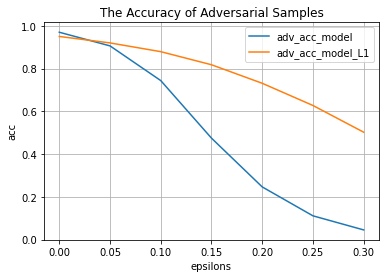

adv_acc_model [0.9696999788284302, 0.9059000015258789, 0.7437000274658203, 0.4745999872684479, 0.24660000205039978, 0.11140000075101852, 0.045499999076128006]
adv_acc_model_L1 [0.949999988079071, 0.9197999835014343, 0.8788999915122986, 0.8177000284194946, 0.7311000227928162, 0.6273000240325928, 0.5023999810218811]


In [ ]:
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.plot(epsilons,adv_acc_list,label='adv_acc_model')
plt.plot(epsilons,adv_acc_list_L1,label='adv_acc_model_L1')
plt.legend()
plt.grid()
plt.show()
print('adv_acc_model',adv_acc_list)
print('adv_acc_model_L1',adv_acc_list_L1)

##5. L’entraînement contradictoire avec la base de données qui est ajoutée les exemples contradictoires.


#### 5.1 Ajouter les perturbation dans la base de données

In [ ]:
perturb = create_adversarial_pattern(train_image, train_labels)
train_adv = train_image+0.3*perturb
train_train_adv = tf.concat([train_image, train_adv], 0) #train_image + train_image with perturbation （120000 images） 
labels_label_adv = tf.concat([train_labels, train_labels], 0) 

dataset_adv = tf.data.Dataset.from_tensor_slices((train_train_adv, labels_label_adv)).shuffle(120000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

In [ ]:
# model training with clean exemples and adversarial exemples 
model_adv = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])
optimizer_adv = tf.keras.optimizers.Adam()
loss_func_adv = tf.keras.losses.SparseCategoricalCrossentropy()
model_adv.compile(optimizer=optimizer,loss=loss_func_adv,metrics=['acc'])
history = model_adv.fit(dataset_adv,validation_data=test_dataset,epochs=10) 

Epoch 1/10
469/469 [==============================] - 6s 10ms/step - loss: 0.3179 - acc: 0.9046 - val_loss: 0.2432 - val_acc: 0.9324
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1320 - acc: 0.9612 - val_loss: 0.2031 - val_acc: 0.9411
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1037 - acc: 0.9694 - val_loss: 0.1554 - val_acc: 0.9525
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0863 - acc: 0.9742 - val_loss: 0.1556 - val_acc: 0.9529
Epoch 5/10
469/469 [==============================] - 4s 7ms/step - loss: 0.0757 - acc: 0.9772 - val_loss: 0.1307 - val_acc: 0.9617
Epoch 6/10
469/469 [==============================] - 4s 7ms/step - loss: 0.0693 - acc: 0.9790 - val_loss: 0.1337 - val_acc: 0.9567
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0614 - acc: 0.9811 - val_loss: 0.1273 - val_acc: 0.9600
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 

#### 5.2 Afficher les résultats

epsilons = 0:
313/313 [==============================] - 1s 2ms/step


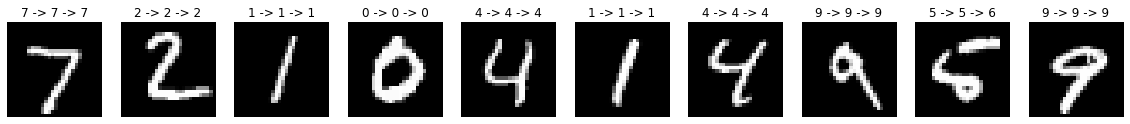

epsilons = 0.05:
313/313 [==============================] - 1s 2ms/step


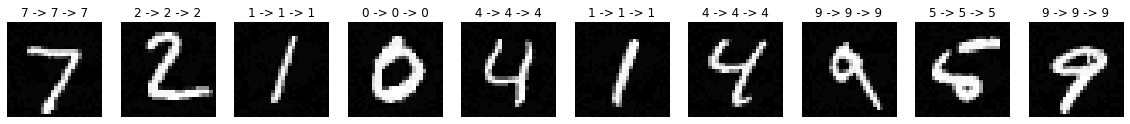

epsilons = 0.1:
313/313 [==============================] - 1s 2ms/step


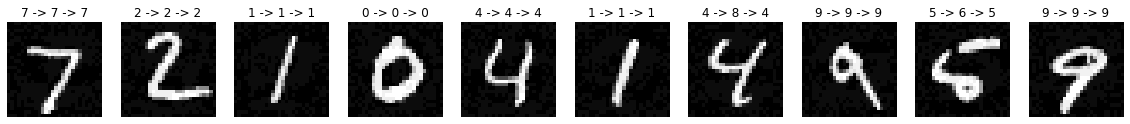

epsilons = 0.15:
313/313 [==============================] - 1s 2ms/step


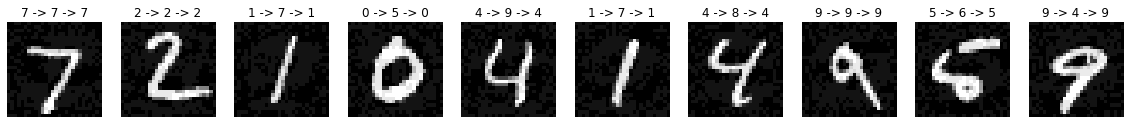

epsilons = 0.2:
313/313 [==============================] - 1s 2ms/step


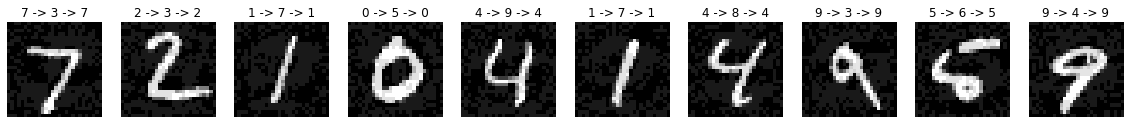

epsilons = 0.25:
313/313 [==============================] - 1s 2ms/step


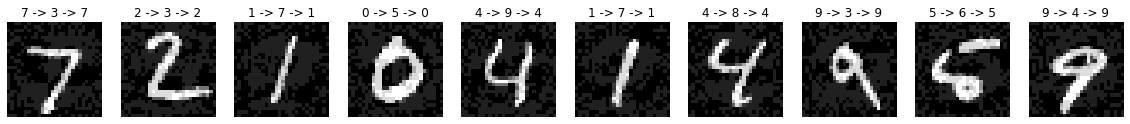

epsilons = 0.3:
313/313 [==============================] - 1s 2ms/step


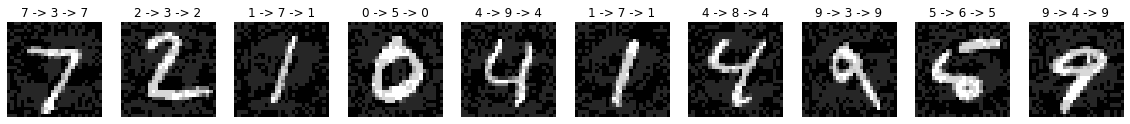

In [ ]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Générer des adversarial pattern
  adv_image = test_image + eps*perturbations      
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  # Obtenir le résultat de la prédiction de l'image d'origine 
  pred = model.predict(test_image) 
  pred = np.array([np.argmax(i) for i in pred])
  # Obtenir le résultat de la prédiction de adversarial exemples en utilisant model original
  pred_adv1 = model.predict(adv_image) 
  pred_adv1 = np.array([np.argmax(i) for i in pred_adv1])
  # Obtenir le résultat de la prédiction de adversarial exemples en utilisant model avec adversarial training 
  pred_adv2 = model_adv.predict(adv_image)
  pred_adv2 = np.array([np.argmax(i) for i in pred_adv2])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score1 = model.evaluate(adv_image,test_labels,verbose=0)
  acc_list.append(score1[1])
  score2 = model_adv.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score2[1])
  # plot
  display_images(adv_image,pred,pred_adv1,pred_adv2, 10)

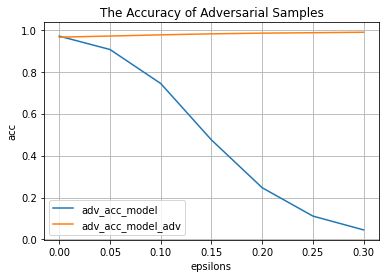

acc [0.9696999788284302, 0.9059000015258789, 0.7437000274658203, 0.4745999872684479, 0.24660000205039978, 0.11140000075101852, 0.045499999076128006]
acc [0.9648000001907349, 0.9702000021934509, 0.9758999943733215, 0.9807000160217285, 0.984000027179718, 0.9861000180244446, 0.9883000254631042]


In [ ]:
plt.figure()
plt.plot(epsilons,acc_list,label='adv_acc_model')
plt.plot(epsilons,adv_acc_list,label='adv_acc_model_adv')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',acc_list)
print('acc',adv_acc_list)